# Binning & Transition Dynamics

In [1]:
from time import time
import numpy as np
from scipy import linalg as la
from scipy import stats as st
from scipy import optimize as opt
from matplotlib import pyplot as plt

from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
plt.rcParams['figure.figsize'] = [8, 5]

## Binning (a.k.a., Non-Stochastic Simulations)

Consider the last model we saw in Class #4.

\begin{align*}
    V(A, Y) = \max_{C, A'} &\; u(C) + \beta\ \mathbf{E} \left( V(A', Y') | A, Y \right) \\
    \text{s.t.} &\;
    \begin{cases}
        C + A' \leq Y + (1 + r) A \\
        A' \geq \underline{A} \\
        P(Y' | Y) = \Pi
    \end{cases}
\end{align*}

In that class, we saw that the exogenous transition matrix $\Pi$ and the policy function $A'(A, Y)$ induce an endogenous ergodic distribution of agents $\lambda(A, Y)$. One key step in obtaining the numerical counterpart of such solution was to recode the policy function on asset holdings as a (degenerate) transition matrix. For every income level $Y_k$ we construct a matrix $\bar{A}^k$ such that

\begin{equation*}
    \bar{A}^k_{[i, j]} =
    \begin{cases}
        1 & \text{ if } A'(A_i, Y_k) = A_j \\
        0 & \text{ if } A'(A_i, Y_k) \neq A_j
    \end{cases}
\end{equation*}

This step introduces a numerical issue. We can interpret the policy function $A'(A, Y)$ as a conditional transition probability, mapping the state $(A, Y)$ into the future state $A'$. By its nature, such transition probability is degenerate in one point. However, forcing the policy function to predict a point $A'$ to lie exactly on the grid for asset holdings introduces an approximation error. Such error may be intolerably big when the grids for the state variables are not dense enough. The naïve approach out of this problem is to take a Monte Carlo approach, by changing randomly some parameter of the model, such that the endogenous distribution $\lambda(A, Y)$ would be slightly shifted. After simulating a large enough number of samples for the distribution, an average would yield the "true" distribution $\lambda(A, Y)$, free of approximation errors.

[Young (2010)](https://www.sciencedirect.com/science/article/abs/pii/S0165188909001316) proposed an alternative approach, which is much less computationally costly. Suppose that, at the particular state $(A_i, Y_k)$, the analytical policy function $A'(A_i, Y_k) = A^* \in (A_j, A_{j+1})$. In words, assume that the policy function demands a value of future asset holdings that is not represented on the numerical grid. Instead of writing a $1$ in the matrix $\bar{A}^k$ on the closest between $A_j$ and $A_{j+1}$ to $A^*$, let us define a weight $\omega$ as

\begin{equation*}
    \omega \equiv \frac{A^* - A_j}{A_{j+1} - A_j} \in (0, 1)
\end{equation*}

The weight $\omega$ will be closer to $0$ if $A^*$ is close to $A_j$. Similarly, $\omega$ will be closer to $1$ if $A^*$ is close to $A_{j+1}$. In other words, the quantity $\omega$ measures the distance between $A^*$ and $A_j$ relative to the space between $A_j$ and $A_{j+1}$. This weight $\omega$ can be interpreted as a probability. Therefore, the generic row $i$ of the matrix $\bar{A}^k$ will now look like

\begin{equation*}
    \begin{bmatrix}
        0 & \cdots & 0 & \omega & 1 - \omega & 0 & \cdots & 0
    \end{bmatrix}
\end{equation*}

The expectation out of this procedure is that the ergodic distribution $\lambda$ will now look smoother than without. Finally, it is important to note that this "binning" approach lets the aggregate quantities unchanged. Let us proceed with verifying this claim and seeing how we can implement it.

In [2]:
class Huggett:


    def __init__(self, a_num, y_num, a_min=-3.0, a_max=15.0, beta=0.97,
                  gamma=2.0, mu=0.0, rho=0.53, sigma=0.296, vfi_tol=1e-6):
        self.na = a_num
        self.ny = y_num
        self.ns = a_num * y_num
        self.a_min = a_min
        self.beta = beta
        self.gamma = gamma
        self.mu = mu
        self.rho = rho
        self.sigma = sigma
        self.A = np.linspace(a_min, a_max, a_num)
        log_Y, self.Pi = self._rouwenhorst(y_num, mu, rho, sigma)
        self.Y = np.exp(log_Y)
        self.vfi_tol = vfi_tol


    def solve_vfi_ip(self, r):
        """
        Solves the households' problem with VFI scaling down the state space.
        """
        na = self.na // 5
        A = np.linspace(self.A.min(), self.A.max(), na)
        V0 = np.zeros((na, self.ny))
        dr = np.zeros((na, self.ny), dtype=int)
        crit = 1.0
        n_iter = 0
        while crit > self.vfi_tol:
            n_iter += 1
            V1 = np.zeros_like(V0)
            U = np.zeros((na, self.ny))
            for i in range(na):
                for k in range(self.ny):
                    C = self.Y[k] + (1 + r) * A[i] - A
                    C[C < 0] = np.nan
                    U[:, k] = self.u(C)
                objective = U + self.beta * ( V0 @ self.Pi.T )
                V1[i, :] = np.nanmax(objective, axis=0)
                dr[i, :] = np.nanargmax(objective, axis=0)
            crit = np.nanmax( np.nanmax( np.abs( V1 - V0 ) ) )
            V0[:] = V1
        pf_a = A[dr]
        A_opt = np.zeros((self.na, self.ny))
        for k in range(self.ny):
            coeffs = np.polyfit(A, pf_a[:, k], 3)
            A_opt[:, k] = np.polyval(coeffs, self.A)
        A_opt[A_opt <= self.A.min()] = self.A.min()
        return A_opt


    def market_clearing(self, r, binning=False, full_output=False):
        t0 = time()
        pfa = self.solve_vfi_ip(r)
        Q = self._compute_Q_smooth(pfa) if binning else self._compute_Q(pfa)
        dist = self._ergodic_distribution(Q).reshape((self.ny, self.na)).T
        net_excess_demand = np.sum(dist * pfa)
        t1 = time()
        print('Done!     r = {0:.5f}%     {1:.3f}s.'.format(r*100, t1-t0))
        if full_output:
            return net_excess_demand, dist
        else:
            return net_excess_demand


    def u(self, c):
        return (c ** (1 - self.gamma)) / (1 - self.gamma)


    @staticmethod
    def _rouwenhorst(n, mu, rho, sigma):
        """
        Discretizes any stationary AR(1) process.
        """
        def compute_P(p, n):
            if n == 2:
                P = np.array([[p, 1-p], [1-p, p]], dtype=float)
            else:
                Q = compute_P(p, n-1)
                A = np.zeros((n, n))
                B = np.zeros((n, n))
                A[:n-1, :n-1] += Q
                A[1:n, 1:n] += Q
                B[:n-1, 1:n] += Q
                B[1:n, :n-1] += Q
                P = p * A + (1-p) * B
                P[1:-1, :] /= 2
            return P
        p = (1 + rho) / 2
        Pi = compute_P(p, n)
        f = np.sqrt(n-1) * (sigma / np.sqrt(1 - rho**2))
        S = np.linspace(-f, f, n) + mu
        return S, Pi


    @staticmethod
    def _ergodic_distribution(P, tol=1e-12):
        """
        Returns the ergodic distribution of a matrix P by iterating it
        """
        n = P.shape[0]
        p0 = np.zeros((1, n))
        p0[0, 0] = 1.0
        diff = 1.0
        while diff > tol:
            p1 = p0 @ P
            p0 = p1 @ P
            diff = la.norm(p1 - p0)
        return p0.reshape((-1, )) / p0.sum()


    def _compute_Q(self, pf_a):
        """
        Translates a policy function into a transition matrix.
        """
        n = self.na
        blocks = []
        for k in range(self.ny):
            pa = np.zeros((n, n), dtype=int)
            for i in range(n):
                j = np.argmin( np.abs( pf_a[i, k] - self.A ) )
                pa[i, j] = 1
            blocks.append(pa)
        PA = la.block_diag(*blocks)
        PY = np.kron( self.Pi, np.eye(self.na) )
        Q = PY @ PA
        return Q


    def _compute_Q_smooth(self, pf_a):
        """
        Translates a policy function into a transition matrix, with binning.
        """
        def locate_and_compute_omega(x0, X):
            """
            Finds j such that X[j] <= x0 < X[j+1]. Only works with 1D arrays.
            """
            if X.ndim > 1:
                raise ValueError('This function only works with 1D arrays.')
            if not np.all( X[1:] - X[:-1] >= 0 ):
                raise ValueError('Array to be searched must be sorted.')
            if x0 < X.min() or x0 > X.max():
                raise ValueError('Target is out of array.')
            i = np.argmin( np.abs( X - x0 ) )
            # is i=j or i=j+1?
            j = i if X[i] - x0 < 0 else i-1
            omega = ( X[j+1] - x0 ) / ( X[j+1] - X[j] )
            return j, omega

        n  = self.na
        blocks = []
        for k in range(self.ny):
            pa = np.zeros((n, n))
            for i in range(n):
                if pf_a[i, k] <= self.A.min():
                    pa[i,  0] = 1.0
                elif pf_a[i, k] >= self.A.max():
                    pa[i, -1] = 1.0
                else:
                    j, omega = locate_and_compute_omega(pf_a[i, k], self.A)
                    pa[i,   j] = omega
                    pa[i, j+1] = 1 - omega
            blocks.append(pa)
        PA = la.block_diag(*blocks)
        PY = np.kron( self.Pi, np.eye(self.na) )
        Q = PY @ PA
        return Q

See that we have written two functions for computing $Q$. One is `Huggett._compute_Q` and the other is `Huggett._compute_Q_smooth`. The latter uses the "binning" approach suggested by Young (2010).

Now we proceed with solving the model.

In [3]:
mdl = Huggett(a_num=500, y_num=5)
rStar, checks = opt.ridder(mdl.market_clearing, 0.020, 0.025, full_output=True)

Done!     r = 2.00000%     7.288s.
Done!     r = 2.50000%     8.076s.
Done!     r = 2.25000%     8.658s.
Done!     r = 2.24781%     8.092s.
Done!     r = 2.12391%     6.860s.
Done!     r = 2.24621%     7.654s.
Done!     r = 2.18506%     7.468s.
Done!     r = 2.24468%     6.606s.
Done!     r = 2.21487%     7.876s.
Done!     r = 2.24340%     7.627s.
Done!     r = 2.22914%     7.238s.
Done!     r = 2.24289%     7.083s.
Done!     r = 2.23601%     6.553s.
Done!     r = 2.23544%     6.508s.
Done!     r = 2.23229%     6.784s.
Done!     r = 2.23541%     6.941s.
Done!     r = 2.23385%     6.484s.
Done!     r = 2.23515%     6.440s.
Done!     r = 2.23528%     6.492s.
Done!     r = 2.23540%     6.464s.
Done!     r = 2.23534%     6.700s.
Done!     r = 2.23540%     9.073s.
Done!     r = 2.23537%     8.551s.
Done!     r = 2.23540%     8.320s.
Done!     r = 2.23538%     8.344s.
Done!     r = 2.23538%     8.939s.
Done!     r = 2.23537%     7.205s.
Done!     r = 2.23537%     7.860s.
Done!     r = 2.2353

In [4]:
checks

      converged: True
           flag: 'converged'
 function_calls: 50
     iterations: 24
           root: 0.02235371278454053

In [5]:
pfa = mdl.solve_vfi_ip(rStar)
ned_bin,   dist_bin   = mdl.market_clearing(rStar, binning=True,  full_output=True)
ned_nobin, dist_nobin = mdl.market_clearing(rStar, binning=False, full_output=True)

Done!     r = 2.23537%     6.332s.
Done!     r = 2.23537%     6.442s.


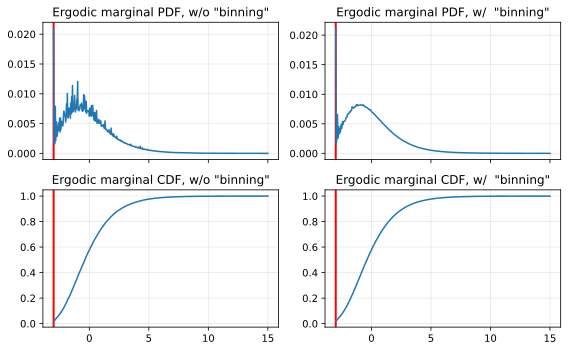

In [6]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True)
for i in range(2):
    for j in range(2):
        ax[i, j].grid(alpha=0.3)
        ax[i, j].axvline(mdl.A.min(), color='red', linewidth=2)
ax[0, 0].plot(mdl.A, dist_nobin.sum(axis=1))
ax[1, 0].plot(mdl.A, dist_nobin.sum(axis=1).cumsum())
ax[0, 1].plot(mdl.A, dist_bin.sum(axis=1))
ax[1, 1].plot(mdl.A, dist_bin.sum(axis=1).cumsum())
ax[0, 0].set_title('Ergodic marginal PDF, w/o "binning"')
ax[1, 0].set_title('Ergodic marginal CDF, w/o "binning"')
ax[0, 1].set_title('Ergodic marginal PDF, w/  "binning"')
ax[1, 1].set_title('Ergodic marginal CDF, w/  "binning"')
plt.tight_layout()
plt.show()

As you can see, the binning approach smoothes out the distribution of agents. The reason relates to how we try (or not) to impose that the policy function $A'(A, Y)$ stays on the grid for asset holdings. The approach by Young (2010) tries to avoid that numerical restriction, without increasing the dimensionality of the problem.

_En passant,_ we have just replicated the paper by Huggett 😉 By comparing the interest rate $r^*$ we obtained here numerically with the one we would obtain in a representative-agent model, we bring home Huggett's main point.

In [7]:
print("  Complete-insurance economy: r = {:.3f}%.".format((1 / mdl.beta - 1)*100))
print("Incomplete-insurance economy: r = {:.3f}%.".format(rStar * 100))

  Complete-insurance economy: r = 3.093%.
Incomplete-insurance economy: r = 2.235%.


## Transition Dynamics (a.k.a., Non-Stochastic Aggregate Shocks)

So far we have seen how to solve models for their general-equilibrium prices. The main goal of these classes are heterogeneous-agents models. The source of heterogeneity lies in idiosyncratic shocks, which give rise to an endogenous distribution of agents. Such distribution is an infinite-dimensional object, on which the equilibrium prices normally depend. The main numerical difficulty with these approaches lies in the number of iterations one normally needs to run. Either VFI or PFI require their time, and they need to be run several times. This means that solving models with idiosyncratic shocks alone can be challenging enough. Adding aggregate shocks with idiosyncratic shocks is going to be even more problematic. The main problem with pairing the two kind of shocks is that aggregate ones are going to shock the endogenous distribution of agents. Keeping track of all this is impractical.

If one wants to study the effect of aggregate shocks on economies with heterogeneous agents, there are two main approaches. One is to resort to mixing projection and perturbation methods, as pioneered by [Reiter (2009)](https://www.sciencedirect.com/science/article/abs/pii/S0165188908001528). These methods essentially rely on solving the model only with idiosyncratic shocks using projection methods. Once the solution has been obtained, one can perturbate the solution around the ergodic distribution of agents to analyze the effects of aggregate shocks. While this method is feasible and extensively used in the literature (e.g., HANK models), it is technically complicated.

The second approach is to use so-called _MIT shocks._ To understand what they are and why they are useful, let us consider the following amendment to the model above.

\begin{align*}
    V(A, Y, Z) = \max_{C, A'} &\; u(C) + \beta\ \mathbf{E} \left( V(A', Y', Z') | A, Y, Z \right) \\
    \text{s.t.} &\;
    \begin{cases}
        C + A' \leq Z \cdot Y + (1 + r) A \\
        A' \geq \underline{A} \\
        P(Y' | Y) = \Pi \\
        Z' = (1 - \rho) \mu + \rho Z + \varepsilon \\
        \varepsilon \sim \mathcal{N}(0, \sigma^2)
    \end{cases}
\end{align*}

Suppose that endowments can be more or less useful to all agents equally. The term $Z$ here acts like an aggregate productivity shock, as well as a state variable. To recap, this model features both aggregate and idiosyncratic uncertainty. Idiosyncratic shocks affect the endowment $Y$. Aggregate shocks $Z$ change the usefulness of the endowments in a way that is common to all households.

Now, instead of solving this model using perturbation-and-projection methods, let us consider the same model, but treating $Z$ as a parameter.

\begin{align*}
    V(A, Y) = \max_{C, A'} &\; u(C) + \beta\ \mathbf{E} \left( V(A', Y') | A, Y \right) \\
    \text{s.t.} &\;
    \begin{cases}
        C + A' \leq Z \cdot Y + (1 + r) A \\
        A' \geq \underline{A} \\
        P(Y' | Y) = \Pi
    \end{cases}
\end{align*}

We can solve this model and treat $Z$ as a parameter, just like $\beta$ for example. Next, we can think of an unexpected shock that permanently change the value of $Z$ to $Z'$. We can the use the policy functions to compute the transition from the equilibrium with $Z$ and the one with $Z'$. This gives us insights over what happens when an aggregate event shocks the economy. Effectively, we are after Impulse-Response Functions in a heterogeneous-agents model. This is the reason _MIT shocks_ are so common in the literature and useful from a practical point of view.

Let us look at how we can numerically obtain transitional dynamics.

In [8]:
# Coming soon...

## The Aiyagari (1994) Model

_Coming soon..._